In [2]:
%matplotlib inline 

import os
from os.path import join, dirname, basename, splitext, exists
import json
import glob

from rasterio.windows import Window
from rasterio.plot import show
import rasterio
from rasterio.profiles import DefaultGTiffProfile
import matplotlib.pyplot as plt
import xmltodict
from shapely.geometry import Polygon
import numpy as np
from shapely.geometry import mapping

In [15]:
data_dir = '/opt/data/alimentiv-histo/'
image_dir = join(data_dir, 'EOE_Images')
label_dir = join(data_dir, 'Layer Data EOE_Images')

output_dir = join(data_dir, 'output')
new_image_dir = join(output_dir, 'images')
new_label_dir = join(output_dir, 'labels')
new_aoi_dir = join(output_dir, 'aois')
new_qgis_aoi_dir = join(output_dir, 'qgis-aois')

def make_dir(dirname):
    if not exists(dirname):
        os.makedirs(dirname)
for dirname in [new_image_dir, new_label_dir, new_aoi_dir, new_qgis_aoi_dir]:
    make_dir(dirname)
        
image_paths = glob.glob(join(image_dir, '*'))
image_fns = [splitext(basename(x))[0] for x in image_paths]
dots_per_mm = {x: 4000 if len(x) == 5 else 5000 for x in image_fns}
label_paths = [join(label_dir, f'{x}.tif') for x in image_fns]
fov_paths = [join(label_dir, f'{x}.xml') for x in image_fns]

In [16]:
id2fov = {}
for fov_path, image_fn in zip(fov_paths, image_fns):
    with open(fov_path) as fd:
        fov_dict = xmltodict.parse(fd.read())
    regions = fov_dict['LayerData']['Regions']
    if regions:
        if len(regions['Object']) != 2:
            print(f'Warning: > 1 FOV in {fov_path}')
        points = regions['Object'][1]['Vertices']['Vertex']
        fov = [(float(p['@X']), float(p['@Y'])) for p in points]
        id2fov[image_fn] = fov

(array([49.,  6.,  2.,  1.,  2.,  0.,  1.,  0.,  0.,  2.]),
 array([ 0.15288403,  1.75628239,  3.35968076,  4.96307913,  6.5664775 ,
         8.16987587,  9.77327424, 11.37667261, 12.98007097, 14.58346934,
        16.18686771]),
 <BarContainer object of 10 artists>)

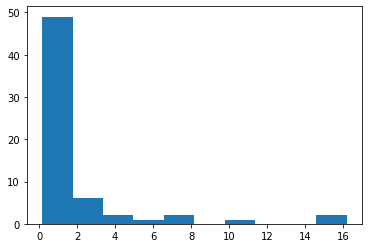

In [17]:
shapes = []
for image_path in image_paths:
    shapes.append(rasterio.open(image_path).shape)

shapes = np.array(shapes)
max_pixels = shapes.max(axis=0).prod()
gbs = shapes.prod(axis=1) / (10 ** 9)
# distribution of images sizes in gigapixels
# we can't load the big ones into RAM
plt.hist(gbs)

In [19]:
for image_fn, image_path in zip(image_fns, image_paths):
    if image_fn not in id2fov:
        continue
    print(f'Processing {image_path}')
    fov = id2fov[image_fn]
    _dots_per_mm = dots_per_mm[image_fn]
    new_label_path = join(new_label_dir, f'{image_fn}.tif')
    new_aoi_path = join(new_aoi_dir, f'{image_fn}.json')
    
    img_src = rasterio.open(image_path)
    img_shape = img_src.shape
    height, width = img_shape
    img_center = np.array([[width, height]]) // 2
        
    label_path = join(label_dir, f'{image_fn}.tif')
    label_src = rasterio.open(label_path)
    label_arr = label_src.read(1)
    label_arr[label_arr != 0] = 1
    
    # convert to image pixel coords
    fov = np.array(fov)
    # negate the y dimension so that the value increases as we go down the array
    # x/y coords here means col/row
    fov[:, 1] *= -1
    fov = ((fov * _dots_per_mm) + img_center).round().astype(int)
    fov_poly = Polygon(fov)
    fov_center = np.array(fov_poly.centroid.xy).squeeze()
    
    # get the offset of the label_arr within the image_arr frame of reference
    label_height, label_width = label_arr.shape
    print(label_arr.shape)
    label_half_width = np.array([label_width, label_height]) // 2
    label_offset = (fov_center - label_half_width).astype(np.int32)

    # save cropped version of image
    new_image_path = join(new_image_dir, f'{image_fn}.tif')
    window = Window(
        label_offset[0], 
        label_offset[1], 
        label_width,
        label_height)
    img_crop = img_src.read(window=window)
    profile = dict(img_src.profile)
    profile['width'] = label_width
    profile['height'] = label_height
    profile['affine'] = img_src.window_transform(window)

    with rasterio.open(new_image_path, 'w', **profile) as dst:
        dst.write(img_crop)
    
    # save new labels
    profile = DefaultGTiffProfile(count=1, width=label_arr.shape[1], height=label_arr.shape[0])
    with rasterio.open(new_label_path, 'w', **profile) as dst:
        dst.write(label_arr, 1)

    # put fov into image frame of reference
    fov = fov - label_offset
            
    # save with y dim negated for visualization in QGIS
    for orientation in ['neg', 'pos']:
        fov[:, 1] *= -1
        fov_poly = Polygon(fov)
        aoi_dict = {
            'type': 'FeatureCollection',
            'features': [
                {
                    'type': 'Feature',
                    'geometry': mapping(fov_poly),
                }
            ]
        }
        out_dir = new_qgis_aoi_dir if orientation == 'neg' else new_aoi_dir
        out_path = join(out_dir, f'{image_fn}.json')
        with open(out_path, 'w') as aoi_fd:
            aoi_fd.write(json.dumps(aoi_dict))

Processing /opt/data/alimentiv-histo/EOE_Images/1.tif
(2766, 2766)
Processing /opt/data/alimentiv-histo/EOE_Images/10.tif
(2766, 2766)
Processing /opt/data/alimentiv-histo/EOE_Images/11.tif
(2766, 2766)
Processing /opt/data/alimentiv-histo/EOE_Images/12.tif
(2766, 2766)
Processing /opt/data/alimentiv-histo/EOE_Images/12002.tiff
(22437, 9126)
Processing /opt/data/alimentiv-histo/EOE_Images/12022.tiff
(2216, 2216)
Processing /opt/data/alimentiv-histo/EOE_Images/12026.tiff
(2216, 2216)
Processing /opt/data/alimentiv-histo/EOE_Images/12030.tiff
(2216, 2216)
Processing /opt/data/alimentiv-histo/EOE_Images/12033.tiff
(2216, 2216)
Processing /opt/data/alimentiv-histo/EOE_Images/12048.tiff
(2216, 2216)
Processing /opt/data/alimentiv-histo/EOE_Images/12053.tiff
(2216, 2216)
Processing /opt/data/alimentiv-histo/EOE_Images/12071.tiff
(2216, 2216)
Processing /opt/data/alimentiv-histo/EOE_Images/12085.tiff
(2216, 2216)
Processing /opt/data/alimentiv-histo/EOE_Images/12100.tiff
(2216, 2216)
Processi